# Data Pre-Processing


Custom Functions to handle data operations.

In [1]:
#@title Code Library
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import pdb
import random
from tqdm import tqdm, tqdm_notebook

def add_dataRow(dataset, dataRow, columns):
  temp_df = pd.DataFrame([dataRow], columns= columns)
  dataset = dataset.append(temp_df, ignore_index= True)
  return dataset

def data_overview(dataset, target_variable):
  df = dataset.drop(columns = target_variable)

  columns = ["Observation", "Value"]
  result_dataset = pd.DataFrame(columns=columns)

  result_dataset = add_dataRow(result_dataset, ["Number of rows", df.shape[0]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of columns", df.shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of numeric variables", df._get_numeric_data().shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of categorical variables", df.select_dtypes(include="category").shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of text & id variables", df.select_dtypes(include=object).shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of logical variables", df.select_dtypes(include="bool").shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of date variables", df.select_dtypes(include="datetime64").shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of uniform variables", df.loc[:,df.apply(pd.Series.nunique) == 1].shape[1]], columns)

  null_df = pd.DataFrame(df.isnull().sum()/df.shape[0],columns=["null_sum"])
  result_dataset = add_dataRow(result_dataset, ["% of complete case rows",(null_df[null_df["null_sum"] == 0].shape[0]*100)/df.shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["% of row with missing values (<50%)",(null_df[null_df["null_sum"] <= 0.5].shape[0]*100)/df.shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["% of row with missing values (>50%)",(null_df[null_df["null_sum"] > 0.5].shape[0]*100)/df.shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["% of row with missing values (>90%)",(null_df[null_df["null_sum"] > 0.9].shape[0]*100)/df.shape[1]], columns)



  return result_dataset

def target_variable_info(dataset, target_variable):
  classes = np.unique(dataset[target_variable])
  
  columns=["Observation","Value"]
  df = pd.DataFrame(columns= columns)

  df = add_dataRow(df, ["Number of classes", len(classes)], columns)
  for xclass in classes:
    value = dataset[dataset[target_variable] == xclass].shape[0]
    df = add_dataRow(df, ["Number of data points in class " + str(xclass), value], columns)

  return df

def df_without_outliers(dataset, col, count=False):
  # pdb.set_trace()
  firstQuantile = dataset[col].quantile(0.25)
  thirdQuantile = dataset[col].quantile(0.75)
  IQR = thirdQuantile - firstQuantile
  leftFence = firstQuantile - (1.5*IQR)
  rightFence = thirdQuantile + (1.5*IQR)
  if count:
    dataset = dataset[(dataset[col] < leftFence) | (dataset[col] > rightFence)]
  else:
    dataset = dataset[(dataset[col] >= leftFence) & (dataset[col] <= rightFence)]

  return dataset

def df_handle_outliers(dataset):
  for col in dataset.columns:
    if col!='TimeStamp':
      Q1 = dataset[col].quantile(0.25)
      Q3 = dataset[col].quantile(0.75)
      IQR = Q3 - Q1
      whisker_width = 1.5
      lower_whisker = Q1 -(whisker_width*IQR)
      upper_whisker = Q3 + (whisker_width*IQR)
      dataset[col]=np.where(dataset[col]>upper_whisker,upper_whisker,np.where(dataset[col]<lower_whisker,lower_whisker,dataset[col]))
  return dataset

def numerical_overview(dataset, target_variable):
  df = dataset.drop(columns= target_variable)._get_numeric_data()

  columns = ["Variable name", "+ve value count", "-ve value count", "Zero count", \
             "Unique count", "+ve infinity count", "-ve infinity count", \
             "missing %", "Count of outliers"]

  result_dataset = pd.DataFrame(columns=columns)

  for col in df.columns:
    dataRow = []

    dataRow.append(col)
    dataRow.append(df[df[col] > 0].shape[0])
    dataRow.append(df[df[col] < 0].shape[0])
    dataRow.append(df[df[col] == 0].shape[0])
    dataRow.append(len(df[col].unique()))
    dataRow.append(df[df[col] == np.inf].shape[0])
    dataRow.append(df[df[col] == -np.inf].shape[0])
    dataRow.append((df[col].isnull().sum()*100)/df.shape[0])
    dataRow.append(df_without_outliers(df, col, True).shape[0])

    result_dataset = add_dataRow(result_dataset, dataRow, columns)

  return result_dataset

def categorical_feature_overview(dataset, target_variable):
  # pdb.set_trace()
  df = dataset.drop(columns= target_variable).select_dtypes(include="category")

  columns = ["Variable name", "Unique categories", "% missing values"]
  result_dataset = pd.DataFrame(columns=columns)

  for col in df.columns:
    dataRow = []

    dataRow.append(col)
    dataRow.append(len(pd.unique(df[col])))
    dataRow.append(round(((df[col].isnull().sum())*100)/df.shape[0], 3))

    result_dataset = add_dataRow(result_dataset, dataRow, columns)

  return result_dataset

def min_text_count(df, col):
  min = -1
  for val in df[col]:
    if not pd.isna(val):
      newMin = len(val.split(" "))
      if min == -1 or min > len(val.split(" ")):
        min = newMin
  
  return min

def max_text_count(df, col):
  max = -1
  for val in df[col]:
    if not pd.isna(val):
      newMax = len(val.split(" "))
      if max == -1 or max < len(val.split(" ")):
        max = newMax
  
  return max

def text_feature_overview(dataset, target_variable):
  df = dataset.drop(columns=target_variable).select_dtypes(include=object)

  columns = ["Variable name", "No. of unique words", "Min no. of words in a document", "Max no. of words in a document", "% missing data"]
  result_dataset = pd.DataFrame(columns=columns)

  for col in df.columns:
    dataRow = []
    if "id" not in col.lower():
      df[col] = df[col].apply(lambda x : re.sub('\W+',' ', str(x).lower()) if not pd.isna(x) else x)
      # print(df[col])
      dataRow.append(col)
      dataRow.append(len(pd.unique(df[col])))
      dataRow.append(min_text_count(df, col))
      dataRow.append(max_text_count(df, col))
      # print((df[col].isnull()))
      dataRow.append(round((df[col].isnull().sum()*100)/df.shape[0], 2))

      result_dataset = add_dataRow(result_dataset, dataRow, columns)

  return result_dataset

def stat_overview(dataset, target_variable):
  df = dataset.drop(columns=target_variable)._get_numeric_data()

  columns = ["Variable name", "Count", "Mean", "Standard deviation", "Variance", \
             "Min", "25th Percentile", "50th Percentile", "75th Percentile", \
             "Max", "10th Percentile", "90th Percentile", "95th Percentile"]
  result_dataset = pd.DataFrame(columns=columns)

  for col in df.columns:
    dataRow = []

    dataRow.append(col)
    dataRow.append(df[col].count())
    dataRow.append(df[col].mean())
    dataRow.append(df[col].std())
    dataRow.append(df[col].var())
    dataRow.append(df[col].min())
    dataRow.append(df[col].quantile(0.25))
    dataRow.append(df[col].quantile(0.50))
    dataRow.append(df[col].quantile(0.75))
    dataRow.append(df[col].max())
    dataRow.append(df[col].quantile(0.10))
    dataRow.append(df[col].quantile(0.90))
    dataRow.append(df[col].quantile(0.95))

    result_dataset = add_dataRow(result_dataset, dataRow, columns)

  return result_dataset

def density_plot(dataset, target_variable, withOutliers = True):
  # pdb.set_trace()
  df = dataset.drop(columns= target_variable)._get_numeric_data()
  fig, axes = plt.subplots(df.shape[1],figsize=(5,df.shape[1]*5))
  for index, col in enumerate(df.columns):
    if "id" not in col:
      if not withOutliers:
        plot_df = df_without_outliers(df, col)
      else:
        plot_df = df[col].copy()
        plot_df = pd.DataFrame(plot_df, columns=[col])
      a = None
      if df.columns.shape[0] != 1:
        a = axes[index]
      sns.distplot(plot_df[col], ax=a)

def box_plot(dataset, target_variable, withOutliers = True):
  # pdb.set_trace()
  df = dataset.drop(columns= target_variable)._get_numeric_data()
  figs, axes = plt.subplots(df.shape[1], figsize = (5, df.shape[1]*5))

  for index, col in enumerate(df.columns):
    if "id" not in col and col != target_variable:
      if not withOutliers:
        plot_df = df_without_outliers(df, col)
      else:
        plot_df = df[col].copy()
        plot_df = pd.DataFrame(plot_df, columns=[col])
      a = None
      if df.columns.shape[0] != 1:
        a = axes[index]
      sns.boxplot(y=plot_df[col], ax=a,orient="v")

def stacked_bar_plot(dataset ,target_variable, top=10):
  # pdb.set_trace()
  data = dataset.select_dtypes(include="category")
  for x_variable in data.columns:

    df = pd.DataFrame(dataset.groupby(x_variable)[target_variable].agg(lambda x : x.eq(1).sum())).reset_index()
    print(df.columns)
    df["total"] = dataset.groupby(x_variable)[target_variable].agg(total="count").reset_index()["total"]
    df.sort_values(by=['total'],inplace=True, ascending=False)

    if df.shape[0] > top:
      df = df[:top]

    ind = np.arange(df.shape[0])

    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, df["total"].values)
    p2 = plt.bar(ind, df[target_variable].values)

    plt.ylabel('Projects')
    plt.title('% of projects aproved state wise')
    plt.xticks(ind, list(df[x_variable].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

## Loading Data

In [2]:
priceData_19 = pd.read_csv(r"..\Datasets\Day-Ahead Price_Hourly\Prices_2019.csv")
priceData_20 = pd.read_csv(r"..\Datasets\Day-Ahead Price_Hourly\Prices_2020.csv")
priceData_21 = pd.read_csv(r"..\Datasets\Day-Ahead Price_Hourly\Prices_2021.csv")
priceData_22 = pd.read_csv(r"..\Datasets\Day-Ahead Price_Hourly\Prices_2022.csv")

raw_priceData = pd.concat([priceData_19,priceData_20,priceData_21,priceData_22])
print(raw_priceData.shape)
raw_priceData.head()


(35064, 2)


,MTU (UTC),Day-ahead Price [EUR/MWh]
0,01.01.2019 00:00 - 01.01.2019 01:00,70.28
1,01.01.2019 01:00 - 01.01.2019 02:00,65.18
2,01.01.2019 02:00 - 01.01.2019 03:00,60.91
3,01.01.2019 03:00 - 01.01.2019 04:00,65.16
4,01.01.2019 04:00 - 01.01.2019 05:00,65.16


In [3]:
priceData=raw_priceData.copy()
priceData['MTU (UTC)'] = priceData['MTU (UTC)'].str.split('-').str[0]
priceData['MTU (UTC)'] = pd.to_datetime(priceData['MTU (UTC)'])
priceData.head()



,MTU (UTC),Day-ahead Price [EUR/MWh]
0,2019-01-01 00:00:00,70.28
1,2019-01-01 01:00:00,65.18
2,2019-01-01 02:00:00,60.91
3,2019-01-01 03:00:00,65.16
4,2019-01-01 04:00:00,65.16


In [4]:
priceData.rename(columns={"MTU (UTC)": "TimeStamp", "Day-ahead Price [EUR/MWh]": "ElectricityPrice"},inplace=True)

In [5]:
energyData_19 = pd.read_csv(r"..\Datasets\Energy Charts diff sources\energy_2019.csv")
energyData_20 = pd.read_csv(r"..\Datasets\Energy Charts diff sources\energy_2020.csv")
energyData_21 = pd.read_csv(r"..\Datasets\Energy Charts diff sources\energy_2021.csv")
energyData_22 = pd.read_csv(r"..\Datasets\Energy Charts diff sources\energy_2022.csv")

raw_energyData = pd.concat([energyData_19,energyData_20,energyData_21,energyData_22])
print(raw_energyData.shape)
raw_energyData.head()

(68172, 10)


,Date (GMT+1),Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,Hydro pumped storage,Others,Wind onshore,Load
0,01-01-2019 0.00,128.9,0.0,35.3,170.1,979.2,0.0,0.0,603.7,3004.2
1,01-01-2019 0.30,128.6,0.0,34.6,219.2,1019.8,0.0,0.0,581.6,2955.4
2,01-01-2019 1.00,128.4,0.0,28.2,225.0,808.3,0.0,0.0,617.8,2877.1
3,01-01-2019 1.30,124.0,0.0,35.5,226.4,691.9,0.0,0.0,610.0,2769.2
4,01-01-2019 2.00,123.4,0.0,35.5,224.6,616.3,0.0,0.0,515.7,2630.9


In [6]:
energyData=raw_energyData.copy()
energyData['Date (GMT+1)'] = pd.to_datetime(energyData['Date (GMT+1)'],format='%d-%m-%Y %H.%M')
energyData.head()

,Date (GMT+1),Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,Hydro pumped storage,Others,Wind onshore,Load
0,2019-01-01 00:00:00,128.9,0.0,35.3,170.1,979.2,0.0,0.0,603.7,3004.2
1,2019-01-01 00:30:00,128.6,0.0,34.6,219.2,1019.8,0.0,0.0,581.6,2955.4
2,2019-01-01 01:00:00,128.4,0.0,28.2,225.0,808.3,0.0,0.0,617.8,2877.1
3,2019-01-01 01:30:00,124.0,0.0,35.5,226.4,691.9,0.0,0.0,610.0,2769.2
4,2019-01-01 02:00:00,123.4,0.0,35.5,224.6,616.3,0.0,0.0,515.7,2630.9


In [7]:
energyData["drop_value"] = energyData['Date (GMT+1)'].dt.minute.isin([30])
energyData.head()

,Date (GMT+1),Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,Hydro pumped storage,Others,Wind onshore,Load,drop_value
0,2019-01-01 00:00:00,128.9,0.0,35.3,170.1,979.2,0.0,0.0,603.7,3004.2,False
1,2019-01-01 00:30:00,128.6,0.0,34.6,219.2,1019.8,0.0,0.0,581.6,2955.4,True
2,2019-01-01 01:00:00,128.4,0.0,28.2,225.0,808.3,0.0,0.0,617.8,2877.1,False
3,2019-01-01 01:30:00,124.0,0.0,35.5,226.4,691.9,0.0,0.0,610.0,2769.2,True
4,2019-01-01 02:00:00,123.4,0.0,35.5,224.6,616.3,0.0,0.0,515.7,2630.9,False


In [8]:
energyData = energyData[energyData['drop_value'] == False]
energyData.head()

,Date (GMT+1),Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,Hydro pumped storage,Others,Wind onshore,Load,drop_value
0,2019-01-01 00:00:00,128.9,0.0,35.3,170.1,979.2,0.0,0.0,603.7,3004.2,False
2,2019-01-01 01:00:00,128.4,0.0,28.2,225.0,808.3,0.0,0.0,617.8,2877.1,False
4,2019-01-01 02:00:00,123.4,0.0,35.5,224.6,616.3,0.0,0.0,515.7,2630.9,False
6,2019-01-01 03:00:00,124.1,0.0,35.6,190.7,451.6,0.0,0.0,490.8,2479.8,False
8,2019-01-01 04:00:00,124.4,0.0,36.0,197.1,458.5,0.0,0.0,397.3,2401.8,False


In [9]:
energyData.reset_index()

,index,Date (GMT+1),Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,Hydro pumped storage,Others,Wind onshore,Load,drop_value
0,0,2019-01-01 00:00:00,128.9,0.0,35.3,170.1,979.2,0.0,0.0,603.7,3004.2,False
1,2,2019-01-01 01:00:00,128.4,0.0,28.2,225.0,808.3,0.0,0.0,617.8,2877.1,False
2,4,2019-01-01 02:00:00,123.4,0.0,35.5,224.6,616.3,0.0,0.0,515.7,2630.9,False
3,6,2019-01-01 03:00:00,124.1,0.0,35.6,190.7,451.6,0.0,0.0,490.8,2479.8,False
4,8,2019-01-01 04:00:00,124.4,0.0,36.0,197.1,458.5,0.0,0.0,397.3,2401.8,False
...,...,...,...,...,...,...,...,...,...,...,...,...
34081,15554,2022-11-21 01:00:00,105.2,196.0,0.0,41.5,437.0,0.0,0.0,2662.1,NaN,False
34082,15556,2022-11-21 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
34083,15558,2022-11-21 03:00:00,104.5,199.6,0.0,41.5,418.5,0.0,0.0,2597.9,NaN,False
34084,15560,2022-11-21 04:00:00,104.5,198.7,0.0,41.5,454.0,0.0,0.0,2309.2,NaN,False


In [10]:
energyData.rename(columns={"Date (GMT+1)": "TimeStamp"},inplace=True)

In [11]:
energyData=energyData.drop(columns=['drop_value'])

In [12]:
demandData_19 = pd.read_excel(r"..\Datasets\Demand_Generation\Demand_2019.xlsx")
demandData_20_21 = pd.read_excel(r"..\Datasets\Demand_Generation\Demand_2020_2021.xlsx")
demandData_22 = pd.read_excel(r"..\Datasets\Demand_Generation\Demand_2022.xlsx")
raw_demandData = pd.concat([demandData_19,demandData_20_21,demandData_22])
print(raw_demandData.shape)
raw_demandData.head()


(140256, 15)


,DateTime,GMT Offset,NI Generation,NI Demand,NI Wind Availability,NI Wind Generation,NI Solar Availability,NI Solar Generation,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Unnamed: 13,NI: Northern Ireland\nIE: Ireland
0,2019-01-01 00:00:00,0,653.097,684.529,528.603,331.564,0.292,0.0,2444.54,3005.92,599.98,599.15,0.4215,NaN,NaN
1,2019-01-01 00:15:00,0,647.814,672.875,531.042,330.755,0.292,0.0,2468.85,2975.35,582.54,582.31,0.4061,NaN,NaN
2,2019-01-01 00:30:00,0,617.944,657.320,534.835,309.784,0.292,0.0,2446.11,2937.55,596.78,596.48,0.4087,NaN,NaN
3,2019-01-01 00:45:00,0,589.480,640.818,519.645,282.319,0.287,0.0,2364.82,2903.44,625.33,625.77,0.4292,NaN,NaN
4,2019-01-01 01:00:00,0,591.209,652.555,494.949,275.899,0.292,0.0,2326.80,2865.43,628.30,626.40,0.4324,NaN,NaN


In [13]:
demandData=raw_demandData.copy()
demandData["drop_value"] = demandData['DateTime'].dt.minute.isin([15,30,45])

In [14]:
demandData = demandData[demandData['drop_value'] == False]
demandData.head()

,DateTime,GMT Offset,NI Generation,NI Demand,NI Wind Availability,NI Wind Generation,NI Solar Availability,NI Solar Generation,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Unnamed: 13,NI: Northern Ireland\nIE: Ireland,drop_value
0,2019-01-01 00:00:00,0,653.097,684.529,528.603,331.564,0.292,0.0,2444.54,3005.92,599.98,599.15,0.4215,NaN,NaN,False
4,2019-01-01 01:00:00,0,591.209,652.555,494.949,275.899,0.292,0.0,2326.80,2865.43,628.30,626.40,0.4324,NaN,NaN,False
8,2019-01-01 02:00:00,0,497.152,613.700,416.473,193.523,0.292,0.0,1993.39,2613.60,517.65,513.24,0.4485,NaN,NaN,False
12,2019-01-01 03:00:00,0,452.127,581.355,355.045,147.197,0.292,0.0,1752.69,2470.13,492.99,489.53,0.4832,NaN,NaN,False
16,2019-01-01 04:00:00,0,424.964,566.805,282.425,109.138,0.292,0.0,1717.17,2384.35,424.52,378.44,0.4460,NaN,NaN,False


In [15]:
demandData.rename(columns={"DateTime": "TimeStamp"},inplace=True)

In [16]:
demandData=demandData.drop(columns=['GMT Offset', 'NI Generation','NI Demand','NI Wind Availability','NI Wind Generation','NI Solar Availability','NI Solar Generation','Unnamed: 13',
                 'NI: Northern Ireland\nIE: Ireland','drop_value'])


In [17]:
demandData.reset_index()

,index,TimeStamp,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP
0,0,2019-01-01 00:00:00,2444.54,3005.92,599.98,599.15,0.4215
1,4,2019-01-01 01:00:00,2326.80,2865.43,628.30,626.40,0.4324
2,8,2019-01-01 02:00:00,1993.39,2613.60,517.65,513.24,0.4485
3,12,2019-01-01 03:00:00,1752.69,2470.13,492.99,489.53,0.4832
4,16,2019-01-01 04:00:00,1717.17,2384.35,424.52,378.44,0.4460
...,...,...,...,...,...,...,...
35059,35020,2022-12-31 19:00:00,3706.56,4115.32,321.07,306.51,0.2145
35060,35024,2022-12-31 20:00:00,3603.50,3865.44,520.18,503.15,0.2394
35061,35028,2022-12-31 21:00:00,3199.47,3650.31,527.51,510.51,0.2904
35062,35032,2022-12-31 22:00:00,2807.23,3450.39,515.50,500.27,0.3378


In [18]:
weatherData = pd.read_csv(r"..\Datasets\Weather\Weather_Dublin.csv")
weatherData.head()

,date,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ww,w,sun,vis,clht,clamt
0,01-01-2019 0.00,0.0,8.8,7.3,5.4,9.0,80,1034.7,9,250,2,11,0.0,30000,999,3
1,01-01-2019 1.00,0.0,8.3,7.0,5.3,9.0,82,1034.7,9,250,2,11,0.0,30000,999,3
2,01-01-2019 2.00,0.0,8.4,7.1,5.4,9.0,82,1034.7,8,240,2,11,0.0,30000,999,3
3,01-01-2019 3.00,0.0,8.6,7.3,5.8,9.2,82,1035.2,8,250,2,11,0.0,30000,30,6
4,01-01-2019 4.00,0.0,8.4,7.3,5.9,9.3,85,1035.5,10,250,2,11,0.0,30000,24,6


In [19]:
weatherData['date'] = pd.to_datetime(weatherData['date'],format='%d-%m-%Y %H.%M')
weatherData.head()

,date,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ww,w,sun,vis,clht,clamt
0,2019-01-01 00:00:00,0.0,8.8,7.3,5.4,9.0,80,1034.7,9,250,2,11,0.0,30000,999,3
1,2019-01-01 01:00:00,0.0,8.3,7.0,5.3,9.0,82,1034.7,9,250,2,11,0.0,30000,999,3
2,2019-01-01 02:00:00,0.0,8.4,7.1,5.4,9.0,82,1034.7,8,240,2,11,0.0,30000,999,3
3,2019-01-01 03:00:00,0.0,8.6,7.3,5.8,9.2,82,1035.2,8,250,2,11,0.0,30000,30,6
4,2019-01-01 04:00:00,0.0,8.4,7.3,5.9,9.3,85,1035.5,10,250,2,11,0.0,30000,24,6


In [20]:
weatherData=weatherData.drop(columns=['ww','w',	'sun',	'vis',	'clht',	'clamt'])

In [21]:
weatherData.head()

,date,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir
0,2019-01-01 00:00:00,0.0,8.8,7.3,5.4,9.0,80,1034.7,9,250
1,2019-01-01 01:00:00,0.0,8.3,7.0,5.3,9.0,82,1034.7,9,250
2,2019-01-01 02:00:00,0.0,8.4,7.1,5.4,9.0,82,1034.7,8,240
3,2019-01-01 03:00:00,0.0,8.6,7.3,5.8,9.2,82,1035.2,8,250
4,2019-01-01 04:00:00,0.0,8.4,7.3,5.9,9.3,85,1035.5,10,250


In [22]:
weatherData.rename(columns={"date": "TimeStamp"},inplace=True)

In [23]:
final_df = pd.merge(demandData,energyData,"left",on="TimeStamp")
final_df.head()

,TimeStamp,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,Hydro pumped storage,Others,Wind onshore,Load
0,2019-01-01 00:00:00,2444.54,3005.92,599.98,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,0.0,0.0,603.7,3004.2
1,2019-01-01 01:00:00,2326.80,2865.43,628.30,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,0.0,0.0,617.8,2877.1
2,2019-01-01 02:00:00,1993.39,2613.60,517.65,513.24,0.4485,123.4,0.0,35.5,224.6,616.3,0.0,0.0,515.7,2630.9
3,2019-01-01 03:00:00,1752.69,2470.13,492.99,489.53,0.4832,124.1,0.0,35.6,190.7,451.6,0.0,0.0,490.8,2479.8
4,2019-01-01 04:00:00,1717.17,2384.35,424.52,378.44,0.4460,124.4,0.0,36.0,197.1,458.5,0.0,0.0,397.3,2401.8


In [24]:
final_df = pd.merge(final_df,weatherData,"left",on="TimeStamp")
final_df.head()

,TimeStamp,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,...,Load,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir
0,2019-01-01 00:00:00,2444.54,3005.92,599.98,599.15,0.4215,128.9,0.0,35.3,170.1,...,3004.2,0.0,8.8,7.3,5.4,9.0,80,1034.7,9,250
1,2019-01-01 01:00:00,2326.80,2865.43,628.30,626.40,0.4324,128.4,0.0,28.2,225.0,...,2877.1,0.0,8.3,7.0,5.3,9.0,82,1034.7,9,250
2,2019-01-01 02:00:00,1993.39,2613.60,517.65,513.24,0.4485,123.4,0.0,35.5,224.6,...,2630.9,0.0,8.4,7.1,5.4,9.0,82,1034.7,8,240
3,2019-01-01 03:00:00,1752.69,2470.13,492.99,489.53,0.4832,124.1,0.0,35.6,190.7,...,2479.8,0.0,8.6,7.3,5.8,9.2,82,1035.2,8,250
4,2019-01-01 04:00:00,1717.17,2384.35,424.52,378.44,0.4460,124.4,0.0,36.0,197.1,...,2401.8,0.0,8.4,7.3,5.9,9.3,85,1035.5,10,250


In [25]:
final_df = pd.merge(final_df,priceData,"left",on="TimeStamp")
final_df.head()

,TimeStamp,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,...,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ElectricityPrice
0,2019-01-01 00:00:00,2444.54,3005.92,599.98,599.15,0.4215,128.9,0.0,35.3,170.1,...,0.0,8.8,7.3,5.4,9.0,80,1034.7,9,250,70.28
1,2019-01-01 01:00:00,2326.80,2865.43,628.30,626.40,0.4324,128.4,0.0,28.2,225.0,...,0.0,8.3,7.0,5.3,9.0,82,1034.7,9,250,65.18
2,2019-01-01 02:00:00,1993.39,2613.60,517.65,513.24,0.4485,123.4,0.0,35.5,224.6,...,0.0,8.4,7.1,5.4,9.0,82,1034.7,8,240,60.91
3,2019-01-01 03:00:00,1752.69,2470.13,492.99,489.53,0.4832,124.1,0.0,35.6,190.7,...,0.0,8.6,7.3,5.8,9.2,82,1035.2,8,250,65.16
4,2019-01-01 04:00:00,1717.17,2384.35,424.52,378.44,0.4460,124.4,0.0,36.0,197.1,...,0.0,8.4,7.3,5.9,9.3,85,1035.5,10,250,65.16


## Data Overview

### Variable names

In [26]:
print("final df columns : {0}\n".format(final_df.columns))

final df columns : Index(['TimeStamp', 'IE Generation', 'IE Demand', 'IE Wind Availability',
       'IE Wind Generation', 'SNSP', 'Hydro Run-of-River', 'Fossil hard coal',
       'Fossil oil', 'Fossil peat', 'Fossil gas', 'Hydro pumped storage',
       'Others', 'Wind onshore', 'Load', 'rain', 'temp', 'wetb', 'dewpt',
       'vappr', 'rhum', 'msl', 'wdsp', 'wddir', 'ElectricityPrice'],
      dtype='object')



### Basic info

In [27]:
print("Dataset info : {0}\n".format(final_df.info()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35064 entries, 0 to 35063
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   TimeStamp             35064 non-null  datetime64[ns]
 1   IE Generation         35064 non-null  float64       
 2   IE Demand             35064 non-null  float64       
 3   IE Wind Availability  35064 non-null  float64       
 4   IE Wind Generation    35064 non-null  float64       
 5   SNSP                  35064 non-null  float64       
 6   Hydro Run-of-River    30889 non-null  float64       
 7   Fossil hard coal      30889 non-null  float64       
 8   Fossil oil            30889 non-null  float64       
 9   Fossil peat           30889 non-null  float64       
 10  Fossil gas            30889 non-null  float64       
 11  Hydro pumped storage  30889 non-null  float64       
 12  Others                30889 non-null  float64       
 13  Wind onshore    

### Overview

In [28]:
data_overview_df = data_overview(final_df, [])
data_overview_df.head(data_overview_df.shape[0])

C:\Users\kagau\AppData\Local\Temp\ipykernel_20784\4271545770.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_20784\4271545770.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_20784\4271545770.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_20784\4271545770.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(t

,Observation,Value
0,Number of rows,35064
1,Number of columns,25
2,Number of numeric variables,24
3,Number of categorical variables,0
4,Number of text & id variables,0
5,Number of logical variables,0
6,Number of date variables,1
7,Number of uniform variables,0
8,% of complete case rows,60.0
9,% of row with missing values (<50%),100.0


## Numerical features overview

In [29]:
num_overview = numerical_overview(final_df.loc[:,final_df.columns[1]:], [])
num_overview.head(num_overview.shape[0])

C:\Users\kagau\AppData\Local\Temp\ipykernel_20784\4271545770.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_20784\4271545770.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_20784\4271545770.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_20784\4271545770.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(t

,Variable name,+ve value count,-ve value count,Zero count,Unique count,+ve infinity count,-ve infinity count,missing %,Count of outliers
0,IE Generation,35064,0,0,32485,0,0,0.000000,224
1,IE Demand,35064,0,0,32429,0,0,0.000000,6
2,IE Wind Availability,35064,0,0,32963,0,0,0.000000,0
3,IE Wind Generation,35046,0,18,32738,0,0,0.000000,0
4,SNSP,35064,0,0,6997,0,0,0.000000,0
5,Hydro Run-of-River,25795,0,5094,2033,0,0,11.906799,0
6,Fossil hard coal,23370,0,7519,3571,0,0,11.906799,1564
7,Fossil oil,27317,0,3572,5236,0,0,11.906799,0
8,Fossil peat,29723,0,1166,2970,0,0,11.906799,0
9,Fossil gas,30889,0,0,13166,0,0,11.906799,0


### Statistical overview

In [30]:
num_stat_overview = stat_overview(final_df.loc[:, final_df.columns[1]:], [])
num_stat_overview.head(num_stat_overview.shape[0])

C:\Users\kagau\AppData\Local\Temp\ipykernel_20784\4271545770.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_20784\4271545770.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_20784\4271545770.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_20784\4271545770.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(t

,Variable name,Count,Mean,Standard deviation,Variance,Min,25th Percentile,50th Percentile,75th Percentile,Max,10th Percentile,90th Percentile,95th Percentile
0,IE Generation,35064,3415.564472,657.505803,4.323139e+05,1518.2300,2941.4425,3354.5250,3840.2125,5981.5100,2617.43900,4317.326,4587.6670
1,IE Demand,35064,3453.132965,624.408974,3.898866e+05,2030.9200,2932.5175,3501.4250,3919.7650,5494.0400,2604.69800,4241.072,4447.7685
2,IE Wind Availability,35064,1298.652172,1019.016300,1.038394e+06,4.7900,407.7450,1041.9750,2046.4525,3969.2900,161.91900,2889.577,3249.6290
3,IE Wind Generation,35064,1168.694217,858.679060,7.373297e+05,0.0000,394.6775,1015.0850,1856.7675,3582.4600,146.92000,2418.830,2696.2205
4,SNSP,35064,0.359166,0.179201,3.211287e-02,0.0017,0.2187,0.3347,0.5141,0.7561,0.13183,0.619,0.6465
5,Hydro Run-of-River,30889,90.009252,64.567039,4.168903e+03,0.0000,27.5000,92.8000,151.3000,218.7000,0.00000,174.300,181.9000
6,Fossil hard coal,30889,196.403519,198.258136,3.930629e+04,0.0000,72.9000,117.8000,294.5000,761.5000,0.00000,502.400,628.9000
7,Fossil oil,30889,268.668808,193.965235,3.762251e+04,0.0000,83.2000,236.8000,438.8000,921.9000,0.00000,485.900,560.6000
8,Fossil peat,30889,141.176199,101.782556,1.035969e+04,0.0000,65.9000,105.8000,217.2000,347.0000,41.50000,326.020,336.8000
9,Fossil gas,30889,893.363916,407.497401,1.660541e+05,16.6000,552.5000,890.1000,1210.3000,1943.8000,385.98000,1454.120,1609.5600


## Univariate Analysis

#### Density plot with outliers

C:\Users\kagau\AppData\Local\Temp\ipykernel_6344\2485368839.py:209: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plot_df[col], ax=a)
C:\Users\kagau\AppData\Local\Temp\ipykernel_6344\2485368839.py:209: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plot_df[col], ax=a)
C:\Users\kagau\AppData\Local

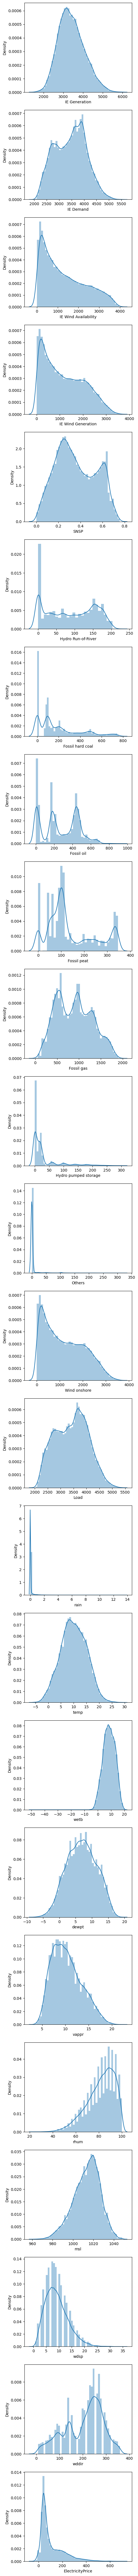

In [72]:
plt.close()
density_plot(final_df.loc[:,final_df.columns[1]:],[])
plt.show()


In [95]:
final_df.head(3)

,TimeStamp,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,...,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ElectricityPrice
0,2019-01-01 00:00:00,2444.54,3005.92,599.98,599.15,0.4215,128.9,0.0,35.3,170.1,...,0.0,8.8,7.3,5.4,9.0,80,1034.7,9,250,70.28
1,2019-01-01 01:00:00,2326.80,2865.43,628.30,626.40,0.4324,128.4,0.0,28.2,225.0,...,0.0,8.3,7.0,5.3,9.0,82,1034.7,9,250,65.18
2,2019-01-01 02:00:00,1993.39,2613.60,517.65,513.24,0.4485,123.4,0.0,35.5,224.6,...,0.0,8.4,7.1,5.4,9.0,82,1034.7,8,240,60.91


In [96]:
finaldf2=df_handle_outliers(final_df)

In [97]:
finaldf2.head(3)

,TimeStamp,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,...,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ElectricityPrice
0,2019-01-01 00:00:00,2444.54,3005.92,599.98,599.15,0.4215,128.9,0.0,35.3,170.1,...,0.0,8.8,7.3,5.4,9.0,80.0,1034.7,9.0,250.0,70.28
1,2019-01-01 01:00:00,2326.80,2865.43,628.30,626.40,0.4324,128.4,0.0,28.2,225.0,...,0.0,8.3,7.0,5.3,9.0,82.0,1034.7,9.0,250.0,65.18
2,2019-01-01 02:00:00,1993.39,2613.60,517.65,513.24,0.4485,123.4,0.0,35.5,224.6,...,0.0,8.4,7.1,5.4,9.0,82.0,1034.7,8.0,240.0,60.91


In [74]:
num_overview2 = numerical_overview(finaldf2.loc[:,finaldf2.columns[1]:], [])
num_overview2.head(num_overview2.shape[0])

C:\Users\kagau\AppData\Local\Temp\ipykernel_6344\2485368839.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_6344\2485368839.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_6344\2485368839.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_6344\2485368839.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_

,Variable name,+ve value count,-ve value count,Zero count,Unique count,+ve infinity count,-ve infinity count,missing %,Count of outliers
0,IE Generation,35064,0,0,32266,0,0,0.000000,0
1,IE Demand,35064,0,0,32424,0,0,0.000000,0
2,IE Wind Availability,35064,0,0,32963,0,0,0.000000,0
3,IE Wind Generation,35046,0,18,32738,0,0,0.000000,0
4,SNSP,35064,0,0,6997,0,0,0.000000,0
5,Hydro Run-of-River,25795,0,5094,2033,0,0,11.906799,0
6,Fossil hard coal,23370,0,7519,2983,0,0,11.906799,0
7,Fossil oil,27317,0,3572,5236,0,0,11.906799,0
8,Fossil peat,29723,0,1166,2970,0,0,11.906799,0
9,Fossil gas,30889,0,0,13166,0,0,11.906799,0


#### Density plot without outliers

C:\Users\kagau\AppData\Local\Temp\ipykernel_6344\2485368839.py:209: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plot_df[col], ax=a)
C:\Users\kagau\AppData\Local\Temp\ipykernel_6344\2485368839.py:209: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plot_df[col], ax=a)
C:\Users\kagau\AppData\Local

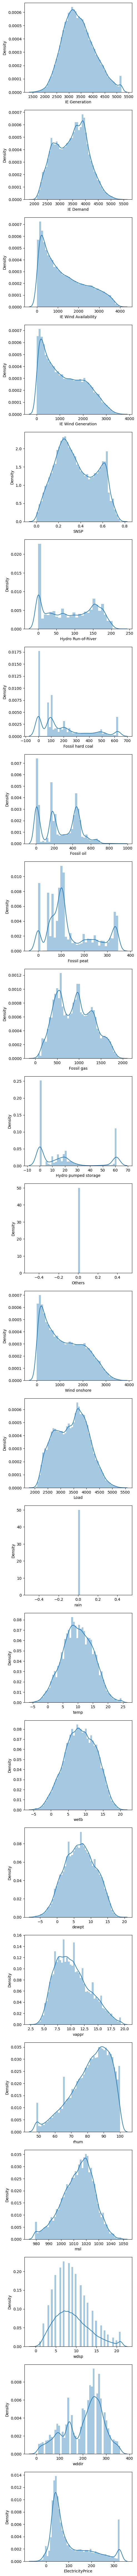

In [75]:
plt.close()
density_plot(finaldf2.loc[:,finaldf2.columns[1]:],[], False)
plt.show()

#### Box plot with Outliers

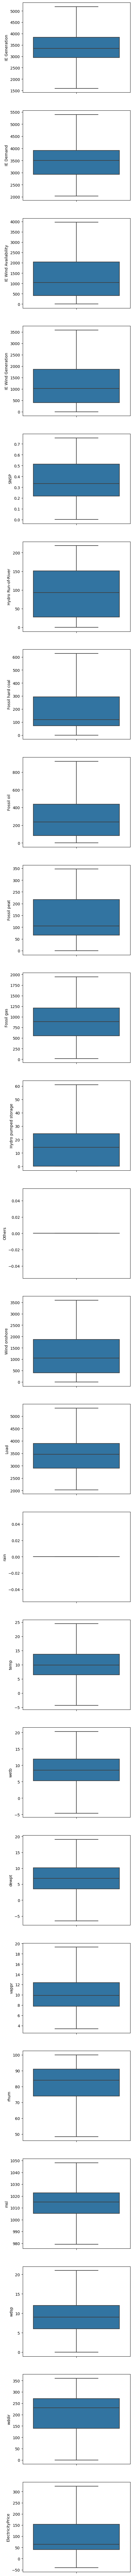

In [76]:
plt.close()
box_plot(final_df.loc[:,final_df.columns[1]:], [])
plt.show()

#### Box plot without outliers

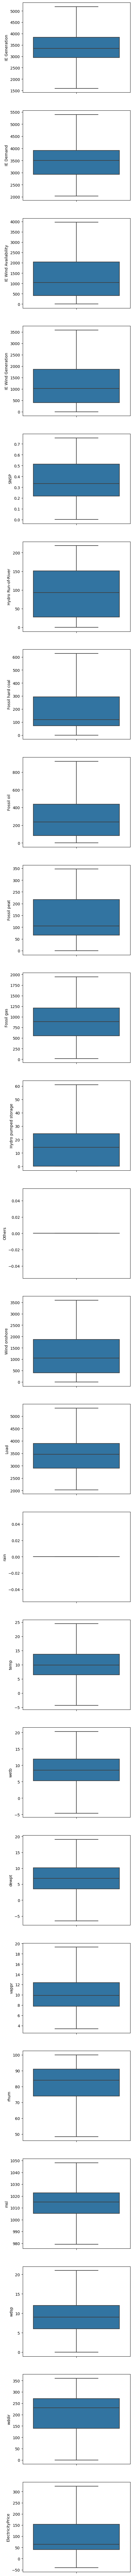

In [77]:
plt.close()
box_plot(finaldf2.loc[:,finaldf2.columns[1]:], [],False)
plt.show()

### Correlation matrix

In [78]:
df = final_df.loc[:,final_df.columns[1]:]._get_numeric_data()
df.corr()

,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,...,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ElectricityPrice
IE Generation,1.000000,0.810901,0.483655,0.546931,0.247061,0.473941,0.175393,-0.016267,0.134193,0.145243,...,NaN,-0.106356,-0.140497,-0.176856,-0.170618,-0.141803,-0.181565,0.354390,0.004992,0.245168
IE Demand,0.810901,1.000000,0.133793,0.195830,0.028399,0.456383,0.313974,0.191847,0.168608,0.276675,...,NaN,-0.041671,-0.099554,-0.164481,-0.154457,-0.246105,-0.063147,0.197098,0.003516,0.343970
IE Wind Availability,0.483655,0.133793,1.000000,0.979126,0.912439,0.265270,-0.219216,-0.516499,-0.058388,-0.522840,...,NaN,-0.076630,-0.096232,-0.124947,-0.136761,-0.110667,-0.410819,0.659541,0.013282,-0.134802
IE Wind Generation,0.546931,0.195830,0.979126,1.000000,0.905528,0.289403,-0.203093,-0.508006,-0.026104,-0.496155,...,NaN,-0.093256,-0.113822,-0.142580,-0.153069,-0.109858,-0.399879,0.645281,0.012797,-0.104801
SNSP,0.247061,0.028399,0.912439,0.905528,1.000000,0.222406,-0.287996,-0.551975,-0.036517,-0.622832,...,NaN,-0.058084,-0.086894,-0.126879,-0.141771,-0.151254,-0.379116,0.631821,0.022748,-0.210317
Hydro Run-of-River,0.473941,0.456383,0.265270,0.289403,0.222406,1.000000,-0.033701,0.035722,0.359239,-0.009696,...,NaN,-0.362928,-0.371229,-0.356365,-0.357285,0.039081,-0.204492,0.205049,0.083363,-0.024625
Fossil hard coal,0.175393,0.313974,-0.219216,-0.203093,-0.287996,-0.033701,1.000000,0.257880,-0.336111,0.021882,...,NaN,-0.043598,-0.028426,-0.004982,0.010168,0.083584,0.145833,-0.173400,0.004174,0.646213
Fossil oil,-0.016267,0.191847,-0.516499,-0.508006,-0.551975,0.035722,0.257880,1.000000,-0.025825,0.156077,...,NaN,0.042193,0.038072,0.036059,0.052155,-0.001943,0.231970,-0.338326,-0.036476,0.090146
Fossil peat,0.134193,0.168608,-0.058388,-0.026104,-0.036517,0.359239,-0.336111,-0.025825,1.000000,0.180888,...,NaN,-0.311086,-0.316306,-0.299053,-0.317059,0.062048,-0.037818,-0.021503,0.052325,-0.273286
Fossil gas,0.145243,0.276675,-0.522840,-0.496155,-0.622832,-0.009696,0.021882,0.156077,0.180888,1.000000,...,NaN,0.016234,0.015987,0.019033,0.020642,0.009523,0.216445,-0.303241,-0.004550,0.127679


In [79]:
df = final_df.loc[:,final_df.columns[1]:]._get_numeric_data()
df.corr(method='spearman')

,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,...,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ElectricityPrice
IE Generation,1.000000,0.799669,0.487256,0.526406,0.256777,0.477684,0.147168,-0.062119,0.157689,0.133729,...,NaN,-0.095465,-0.131828,-0.167785,-0.167850,-0.194906,-0.188204,0.360829,-0.027183,0.225178
IE Demand,0.799669,1.000000,0.123145,0.164715,0.032325,0.455926,0.289754,0.174877,0.191258,0.268789,...,NaN,-0.044641,-0.098131,-0.158265,-0.158335,-0.272503,-0.062332,0.200597,-0.005534,0.392547
IE Wind Availability,0.487256,0.123145,1.000000,0.992720,0.911085,0.272274,-0.188049,-0.547476,-0.038776,-0.515537,...,NaN,-0.094594,-0.117242,-0.134687,-0.134769,-0.145805,-0.411051,0.636703,-0.056162,-0.163813
IE Wind Generation,0.526406,0.164715,0.992720,1.000000,0.903489,0.288291,-0.175649,-0.537353,-0.021569,-0.495257,...,NaN,-0.104263,-0.127665,-0.145512,-0.145594,-0.146725,-0.404388,0.630055,-0.056256,-0.137675
SNSP,0.256777,0.032325,0.911085,0.903489,1.000000,0.228298,-0.249176,-0.564876,-0.038104,-0.623650,...,NaN,-0.069145,-0.101714,-0.132031,-0.132081,-0.190713,-0.383719,0.621878,-0.049404,-0.216344
Hydro Run-of-River,0.477684,0.455926,0.272274,0.288291,0.228298,1.000000,-0.040912,0.014803,0.345178,-0.010273,...,NaN,-0.375922,-0.384385,-0.365139,-0.365125,0.000142,-0.199487,0.208077,0.049250,-0.018806
Fossil hard coal,0.147168,0.289754,-0.188049,-0.175649,-0.249176,-0.040912,1.000000,0.216173,-0.299028,0.005280,...,NaN,-0.031859,-0.018490,-0.000759,-0.000797,0.088672,0.108697,-0.147019,0.017634,0.651137
Fossil oil,-0.062119,0.174877,-0.547476,-0.537353,-0.564876,0.014803,0.216173,1.000000,0.007516,0.168662,...,NaN,0.030376,0.030582,0.026374,0.026307,0.028217,0.250163,-0.347737,0.003452,0.175550
Fossil peat,0.157689,0.191258,-0.038776,-0.021569,-0.038104,0.345178,-0.299028,0.007516,1.000000,0.183003,...,NaN,-0.317017,-0.327372,-0.315041,-0.314948,0.027050,-0.000675,-0.027000,0.048110,-0.179347
Fossil gas,0.133729,0.268789,-0.515537,-0.495257,-0.623650,-0.010273,0.005280,0.168662,0.183003,1.000000,...,NaN,0.026446,0.026323,0.025015,0.024954,0.026049,0.220667,-0.295805,0.037776,0.094220


In [80]:
df = finaldf2.loc[:,finaldf2.columns[1]:]._get_numeric_data()
df.corr(method='spearman')

,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,...,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ElectricityPrice
IE Generation,1.000000,0.799669,0.487256,0.526406,0.256777,0.477684,0.147168,-0.062119,0.157689,0.133729,...,NaN,-0.095465,-0.131828,-0.167785,-0.167850,-0.194906,-0.188204,0.360829,-0.027183,0.225178
IE Demand,0.799669,1.000000,0.123145,0.164715,0.032325,0.455926,0.289754,0.174877,0.191258,0.268789,...,NaN,-0.044641,-0.098131,-0.158265,-0.158335,-0.272503,-0.062332,0.200597,-0.005534,0.392547
IE Wind Availability,0.487256,0.123145,1.000000,0.992720,0.911085,0.272274,-0.188049,-0.547476,-0.038776,-0.515537,...,NaN,-0.094594,-0.117242,-0.134687,-0.134769,-0.145805,-0.411051,0.636703,-0.056162,-0.163813
IE Wind Generation,0.526406,0.164715,0.992720,1.000000,0.903489,0.288291,-0.175649,-0.537353,-0.021569,-0.495257,...,NaN,-0.104263,-0.127665,-0.145512,-0.145594,-0.146725,-0.404388,0.630055,-0.056256,-0.137675
SNSP,0.256777,0.032325,0.911085,0.903489,1.000000,0.228298,-0.249176,-0.564876,-0.038104,-0.623650,...,NaN,-0.069145,-0.101714,-0.132031,-0.132081,-0.190713,-0.383719,0.621878,-0.049404,-0.216344
Hydro Run-of-River,0.477684,0.455926,0.272274,0.288291,0.228298,1.000000,-0.040912,0.014803,0.345178,-0.010273,...,NaN,-0.375922,-0.384385,-0.365139,-0.365125,0.000142,-0.199487,0.208077,0.049250,-0.018806
Fossil hard coal,0.147168,0.289754,-0.188049,-0.175649,-0.249176,-0.040912,1.000000,0.216173,-0.299028,0.005280,...,NaN,-0.031859,-0.018490,-0.000759,-0.000797,0.088672,0.108697,-0.147019,0.017634,0.651137
Fossil oil,-0.062119,0.174877,-0.547476,-0.537353,-0.564876,0.014803,0.216173,1.000000,0.007516,0.168662,...,NaN,0.030376,0.030582,0.026374,0.026307,0.028217,0.250163,-0.347737,0.003452,0.175550
Fossil peat,0.157689,0.191258,-0.038776,-0.021569,-0.038104,0.345178,-0.299028,0.007516,1.000000,0.183003,...,NaN,-0.317017,-0.327372,-0.315041,-0.314948,0.027050,-0.000675,-0.027000,0.048110,-0.179347
Fossil gas,0.133729,0.268789,-0.515537,-0.495257,-0.623650,-0.010273,0.005280,0.168662,0.183003,1.000000,...,NaN,0.026446,0.026323,0.025015,0.024954,0.026049,0.220667,-0.295805,0.037776,0.094220


In [83]:
pd.DataFrame(df.corr(method='spearman')).to_csv("..\\Datasets\\CorrData.csv")

Removing the columns that are highly correlated and has single values in the dataset.

In [98]:
final_df2=finaldf2.drop(columns=['Others', 'Wind onshore','Load','rain','Hydro pumped storage','wetb','dewpt','vappr','msl','wddir','wdsp','IE Wind Availability'])
final_df2.shape

(35064, 13)

In [99]:
final_df2.head(3)

,TimeStamp,IE Generation,IE Demand,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,ElectricityPrice
0,2019-01-01 00:00:00,2444.54,3005.92,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,70.28
1,2019-01-01 01:00:00,2326.80,2865.43,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,65.18
2,2019-01-01 02:00:00,1993.39,2613.60,513.24,0.4485,123.4,0.0,35.5,224.6,616.3,8.4,82.0,60.91


In [100]:
final_df2['TimeStamp'] = pd.to_datetime(final_df2['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')


In [101]:
final_df2=final_df2.drop(final_df2[final_df2['TimeStamp']>pd.to_datetime('29-06-2022  23:00:00')].index)
final_df2.shape

(30623, 13)

In [102]:
final_df2=final_df2.drop_duplicates(subset=['TimeStamp'])
final_df2.shape

(30620, 13)

In [103]:
final_df2 = final_df2.set_index('TimeStamp')
final_df2.head(2)

,IE Generation,IE Demand,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,ElectricityPrice
TimeStamp,,,,,,,,,,,,
2019-01-01 00:00:00,2444.54,3005.92,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,70.28
2019-01-01 01:00:00,2326.80,2865.43,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,65.18


Creating a single merged file for easy operation.

In [108]:
num_overview2 = numerical_overview(final_df2.loc[:,final_df2.columns[0]:], [])
num_overview2.head(num_overview2.shape[0])

C:\Users\kagau\AppData\Local\Temp\ipykernel_6344\4271545770.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_6344\4271545770.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_6344\4271545770.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_6344\4271545770.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_

,Variable name,+ve value count,-ve value count,Zero count,Unique count,+ve infinity count,-ve infinity count,missing %,Count of outliers
0,IE Generation,30620,0,0,28477,0,0,0.000000,0
1,IE Demand,30620,0,0,28665,0,0,0.000000,0
2,IE Wind Generation,30602,0,18,28849,0,0,0.000000,0
3,SNSP,30620,0,0,6776,0,0,0.000000,0
4,Hydro Run-of-River,25064,0,5094,2033,0,0,1.508818,0
5,Fossil hard coal,22645,0,7513,2976,0,0,1.508818,0
6,Fossil oil,26801,0,3357,5229,0,0,1.508818,0
7,Fossil peat,28992,0,1166,2962,0,0,1.508818,0
8,Fossil gas,30158,0,0,13054,0,0,1.508818,0
9,temp,29985,597,38,275,0,0,0.000000,0


In [107]:
final_df2=df_handle_outliers(final_df2)

In [109]:
final_df2.to_excel("..\\Datasets\\inputdata.xlsx")  

Analysing trends for electricity price across the timeline.

Text(0, 0.5, 'ElectricityPrice')

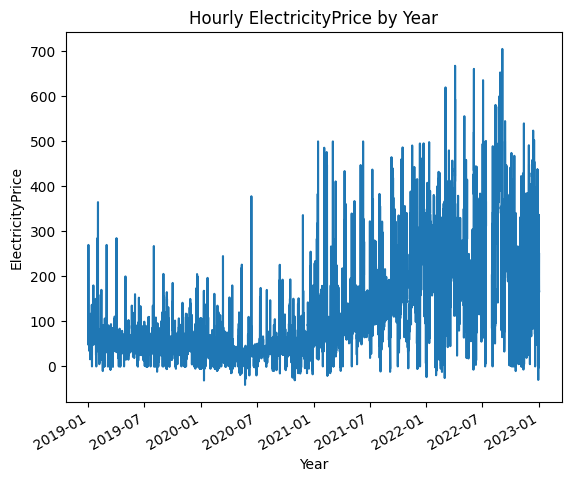

In [ ]:
plt.plot(final_df.TimeStamp, final_df.ElectricityPrice)
plt.title('Hourly ElectricityPrice by Year')
plt.xticks(rotation=30, ha='right')
plt.xlabel('Year')
plt.ylabel('ElectricityPrice')

Text(0, 0.5, 'Demand')

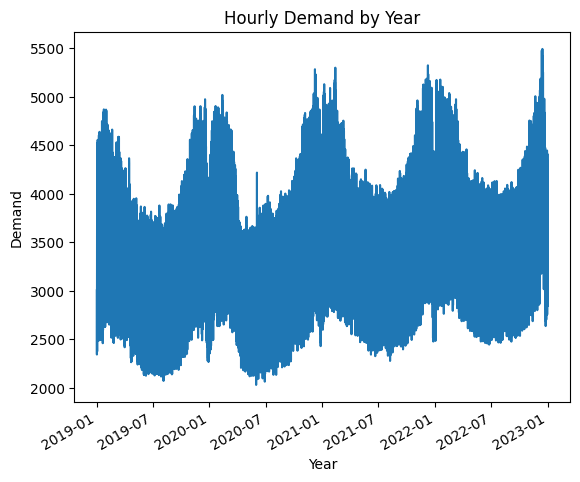

In [31]:
plt.plot(final_df.TimeStamp, final_df['IE Demand'])
plt.title('Hourly Demand by Year')
plt.xticks(rotation=30, ha='right')
plt.xlabel('Year')
plt.ylabel('Demand')

In [32]:
means = final_df.groupby(pd.Grouper(key='TimeStamp', freq='D'))['ElectricityPrice_L'].mean()
means.head()

TimeStamp
2019-01-01    3020.414583
2019-01-02    3460.918333
2019-01-03    3591.468333
2019-01-04    3598.552500
2019-01-05    3343.432500
Freq: D, Name: IE Demand, dtype: float64

In [33]:
meansD = final_df.groupby(pd.Grouper(key='TimeStamp', freq='D'))['IE Demand'].mean()
meansD.head()

TimeStamp
2019-01-01    3020.414583
2019-01-02    3460.918333
2019-01-03    3591.468333
2019-01-04    3598.552500
2019-01-05    3343.432500
Freq: D, Name: IE Demand, dtype: float64

Text(0, 0.5, 'ElectricityPrice')

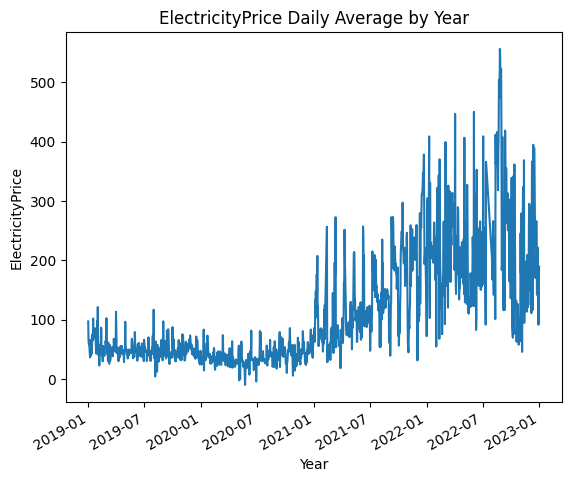

In [ ]:
plt.plot(means)
plt.title('ElectricityPrice Daily Average by Year')
plt.xticks(rotation=30, ha='right')
plt.xlabel('Year')
plt.ylabel('ElectricityPrice')

Text(0, 0.5, 'Demand')

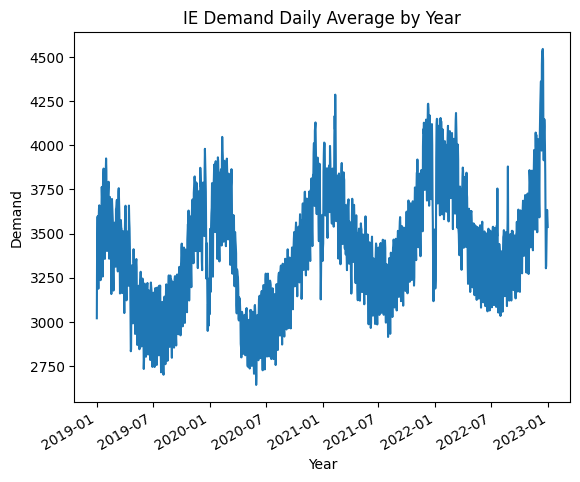

In [35]:
plt.plot(meansD)
plt.title('IE Demand Daily Average by Year')
plt.xticks(rotation=30, ha='right')
plt.xlabel('Year')
plt.ylabel('Demand')

In [ ]:
monthlymean= final_df.groupby(pd.Grouper(key='TimeStamp', freq='M'))['ElectricityPrice'].mean()
monthlymean.head()

TimeStamp
2019-01-31    64.867715
2019-02-28    53.297336
2019-03-31    49.427052
2019-04-30    49.382319
2019-05-31    48.396035
Freq: M, Name: ElectricityPrice, dtype: float64

In [36]:
monthlymeanD= final_df.groupby(pd.Grouper(key='TimeStamp', freq='M'))['IE Demand'].mean()
monthlymeanD.head()

TimeStamp
2019-01-31    3572.675645
2019-02-28    3561.799449
2019-03-31    3471.246972
2019-04-30    3343.061278
2019-05-31    3157.463710
Freq: M, Name: IE Demand, dtype: float64

Text(0, 0.5, 'ElectricityPrice')

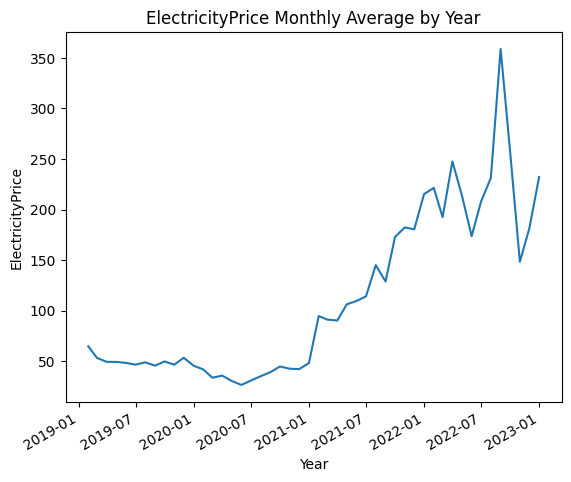

In [ ]:
plt.plot(monthlymean)
plt.title('ElectricityPrice Monthly Average by Year')
plt.xticks(rotation=30, ha='right')
plt.xlabel('Year')
plt.ylabel('ElectricityPrice')

Text(0, 0.5, 'Demand')

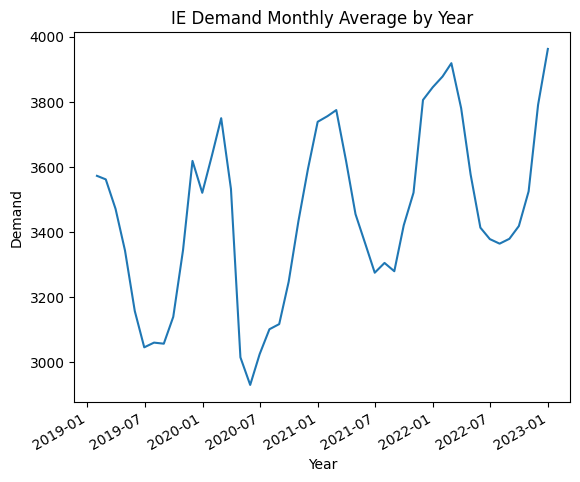

In [37]:
plt.plot(monthlymeanD)
plt.title('IE Demand Monthly Average by Year')
plt.xticks(rotation=30, ha='right')
plt.xlabel('Year')
plt.ylabel('Demand')

In [ ]:
qtrmean= final_df.groupby(pd.Grouper(key='TimeStamp', freq='Q'))['ElectricityPrice'].mean()
qtrmean.head()

TimeStamp
2019-03-31    55.952612
2019-06-30    48.144574
2019-09-30    48.142473
2019-12-31    48.569524
2020-03-31    37.215602
Freq: Q-DEC, Name: ElectricityPrice, dtype: float64

Text(0, 0.5, 'ElectricityPrice')

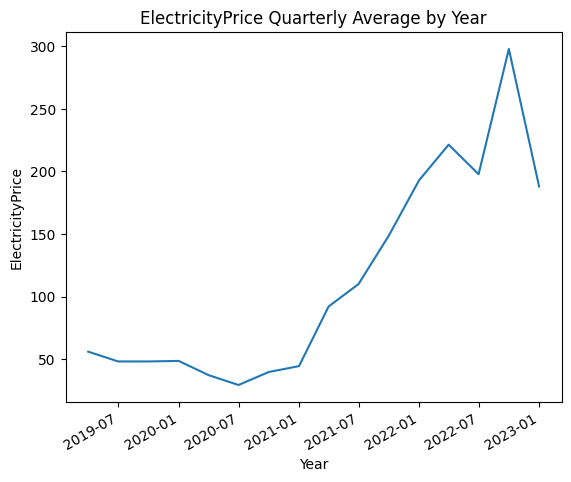

In [ ]:
plt.plot(qtrmean)
plt.title('ElectricityPrice Quarterly Average by Year')
plt.xticks(rotation=30, ha='right')
plt.xlabel('Year')
plt.ylabel('ElectricityPrice')

In [ ]:
dailydf = means.to_frame().reset_index()
dailydf.head()


,TimeStamp,ElectricityPrice_L
0,2019-01-01,97.002917
1,2019-01-02,66.610000
2,2019-01-03,59.060000
3,2019-01-04,56.386667
4,2019-01-05,54.106250


In [ ]:
final_df['ElectricityPrice_L']= final_df['ElectricityPrice'].interpolate(method='linear')

In [ ]:
dailymeans = final_df.groupby(pd.Grouper(key='TimeStamp', freq='D'))['ElectricityPrice_L'].mean()
dailymeans.head()

TimeStamp
2019-01-01    97.002917
2019-01-02    66.610000
2019-01-03    59.060000
2019-01-04    56.386667
2019-01-05    54.106250
Freq: D, Name: ElectricityPrice_L, dtype: float64

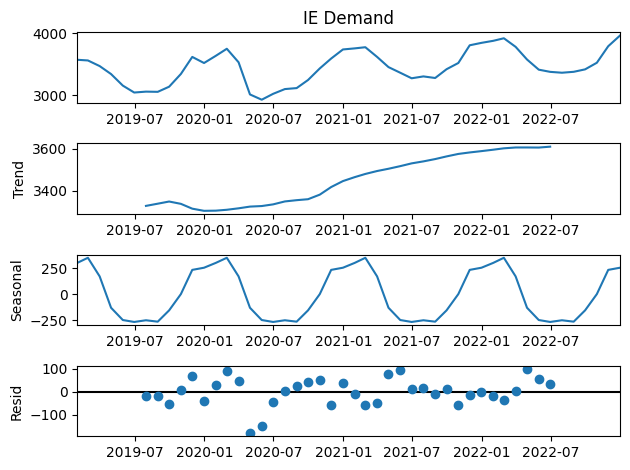

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result_mult = seasonal_decompose(monthlymeanD, model="addictive")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

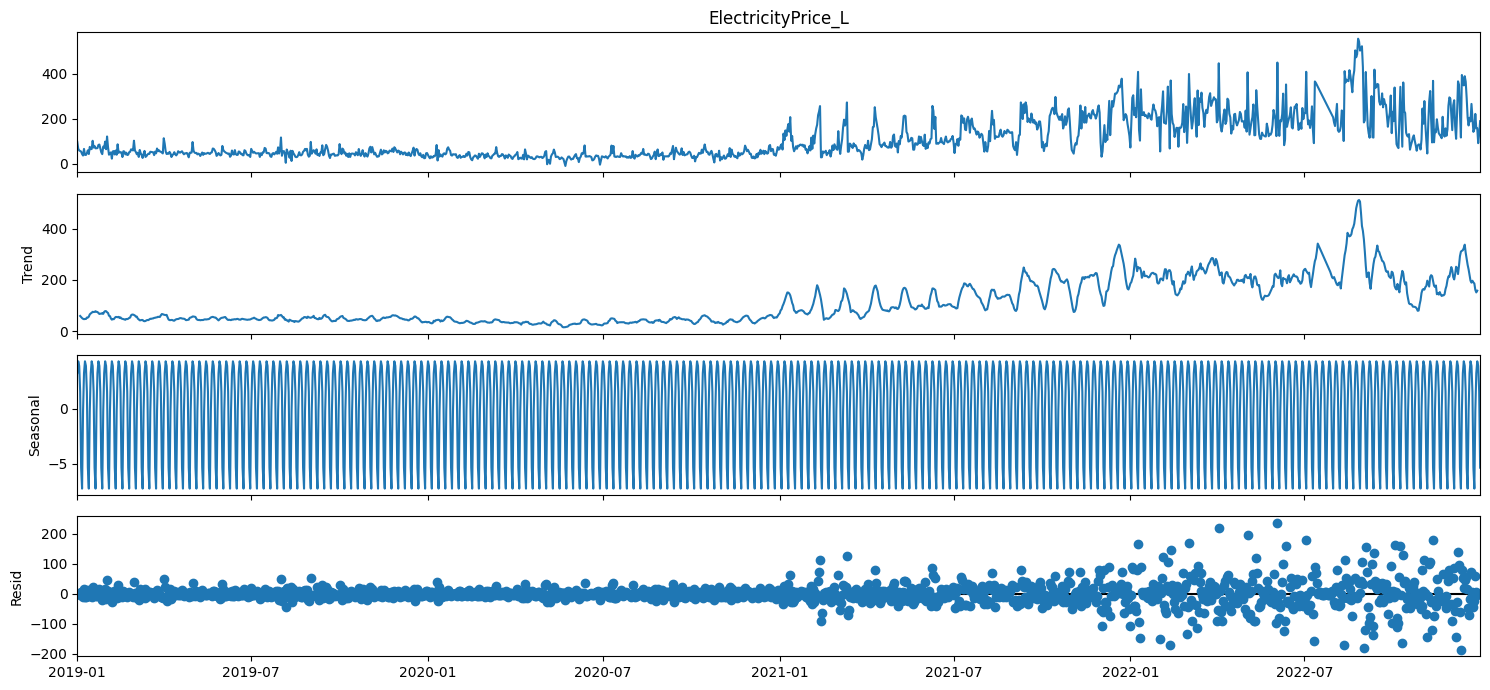

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result_mult = seasonal_decompose(dailymeans, model="addictive")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

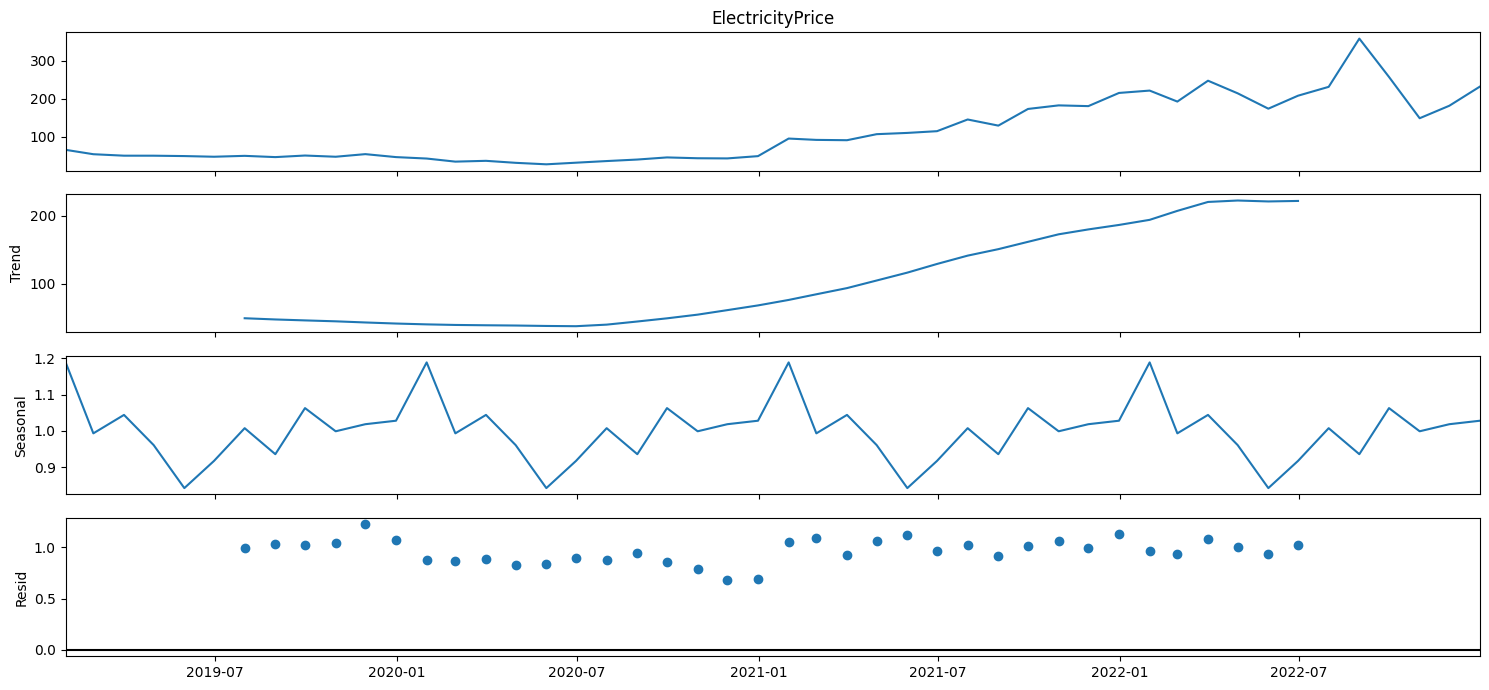

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result_mult = seasonal_decompose(monthlymean, model="multiplicative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

In [ ]:
import plotly.express as px

In [ ]:
newdf = monthlymean.to_frame().reset_index()
newdf.head()

,TimeStamp,ElectricityPrice
0,2019-01-31,64.867715
1,2019-02-28,53.297336
2,2019-03-31,49.427052
3,2019-04-30,49.382319
4,2019-05-31,48.396035


In [ ]:
newdf['TimeStamp'] = pd.to_datetime(newdf['TimeStamp'])
newdf['year'] = newdf['TimeStamp'].dt.year
newdf['day'] = newdf['TimeStamp'].dt.day
newdf['month'] = newdf['TimeStamp'].dt.month_name().str[:3]
#newdf = newdf.pivot_table(index='year', columns='month', values='ElectricityPrice', aggfunc='sum')
newdf.head()

,TimeStamp,ElectricityPrice,year,day,month
0,2019-01-31,64.867715,2019,31,Jan
1,2019-02-28,53.297336,2019,28,Feb
2,2019-03-31,49.427052,2019,31,Mar
3,2019-04-30,49.382319,2019,30,Apr
4,2019-05-31,48.396035,2019,31,May


In [ ]:
fig = px.line_polar( newdf,r="ElectricityPrice", theta="month", color="year", line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma_r,
                    template="plotly_dark",)
fig.show()

c:\Users\kagau\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotly\express\_core.py:271: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trace_data = trace_data.append(trace_data.iloc[0])
c:\Users\kagau\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotly\express\_core.py:271: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trace_data = trace_data.append(trace_data.iloc[0])
c:\Users\kagau\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotly\express\_core.py:271: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trace_data = trace_data.append(trace_data.iloc[0])
c:\Users\kagau\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotly\express\_core.py:271: FutureWarning: The frame.append me

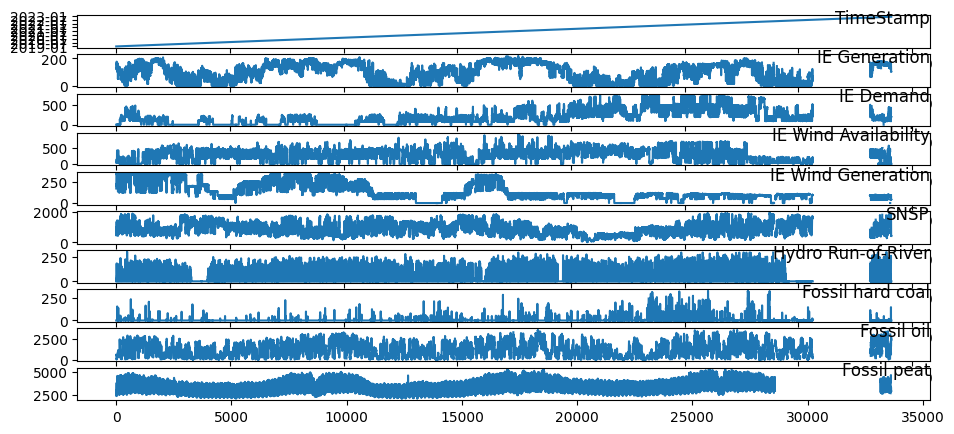

In [ ]:
values = energyData.values
# specify columns to plot
groups = range(0,10)
i = 1
# plot each column
plt.figure()
for group in groups:
 plt.subplot(len(groups), 1, i)
 plt.plot(values[:, group])
 plt.title(final_df.columns[group], y=0.5, loc='right')
 i += 1
plt.rc("figure", figsize=(50,30))
plt.show()

In [ ]:
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [ ]:
modeldata = final_df[['TimeStamp', 'ElectricityPrice_L']]
modeldata.head()

,TimeStamp,ElectricityPrice_L
0,2019-01-01 00:00:00,70.28
1,2019-01-01 01:00:00,65.18
2,2019-01-01 02:00:00,60.91
3,2019-01-01 03:00:00,65.16
4,2019-01-01 04:00:00,65.16


In [ ]:
from statsmodels.graphics.tsaplots  import plot_acf,plot_pacf

In [ ]:
from scipy import fft
from scipy import signal as sig
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from pmdarima import model_selection

In [ ]:
result = adfuller(final_df['ElectricityPrice_L'])

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

ADF Statistic: -7.811768
p-value: 0.000000


In [ ]:

#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(modeldata['ElectricityPrice_L'].diff().diff().dropna(), autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -52.470855
p-value                            0.000000
#Lags Used                        52.000000
Number of Observations Used    35009.000000
Critical Value (1%)               -3.430537
Critical Value (5%)               -2.861623
Critical Value (10%)              -2.566814
dtype: float64
